In [1]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
from scipy.optimize import fsolve
import pandas as pd
from ADRpy import unitconversions as uc
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at
from ADRpy import airworthiness as aw
from ADRpy.propulsion import Piston, EngineDeck
import ADRpy

In [2]:
at.Atmosphere().EAS_TAS(126, uc.ft_m(8500))

143.22632903245696

In [3]:
nturn = 1 / np.cos(np.radians(60))  # Approx. load factor for 60 degrees of bank

S = 16.17
L = uc.lbf_N(2550)

V_clean = uc.kts_mps(53)
V_spoil = uc.kts_mps(48)

cl_clean = 2*L/(1.225*V_clean*V_clean*S) # about 1.5
cl_spoil = 2*L/(1.225*V_spoil*V_spoil*S) # about 1.9

AR = (11**2) / S

rho_f = 6.01 # pounds per gallon
fuel_to_cruise = 3.2 # gallons, from fig 5-7
weight_lost = rho_f * fuel_to_cruise
weight_fraction = (2550 - weight_lost)/2550

# all taken from pilot's operating handbook
designbrief = {
    "rwyelevation_m": 0.0, "groundrun_m": uc.ft_m(960),               
    "turnalt_m": 0, "turnspeed_ktas": 102, "stloadfactor": nturn,     
    "climbalt_m": 0, "climbspeed_kias": 74, 'climbrate_fpm': 730,     
    "cruisealt_m": uc.ft_m(8500), "cruisespeed_ktas": at.Atmosphere().EAS_TAS(129, uc.ft_m(8500)),   
    "cruisethrustfact": 1,                                         
    "servceil_m": uc.ft_m(14000), "secclimbspd_kias": 74,             
    "vstallclean_kcas": 53,                                           
    "groundrun_m": uc.ft_m(925),
    
}

designdefinition = {
    "aspectratio": AR, 
    "taperratio": 3.3/4.8, # estimated from three-view
    "weight_n": L,    # MTOW, from POH
    "sweep_mt_deg": 0.0,                      # Assume unswept main spar along max thickness line 
    "weightfractions": {"cruise": weight_fraction}
}

designperformance = {
    "CDmin": 0.025, "CLmax": cl_clean, 
    "CLmin": -0.4*cl_clean,  # defined in 14 CFR 23.3357 3b
    "mu_R": 0.03, "CLTO": 0.590, # calculated
    "CLmaxTO": 1.69,     # Take-off specific performance
    "CLmaxHL": cl_spoil,
}

designatm = at.Atmosphere()

designpropulsion = "Piston"

concept = ca.AircraftConcept(
    brief=designbrief,
    design=designdefinition,
    performance=designperformance,
    atmosphere=designatm,
    propulsion=designpropulsion
)


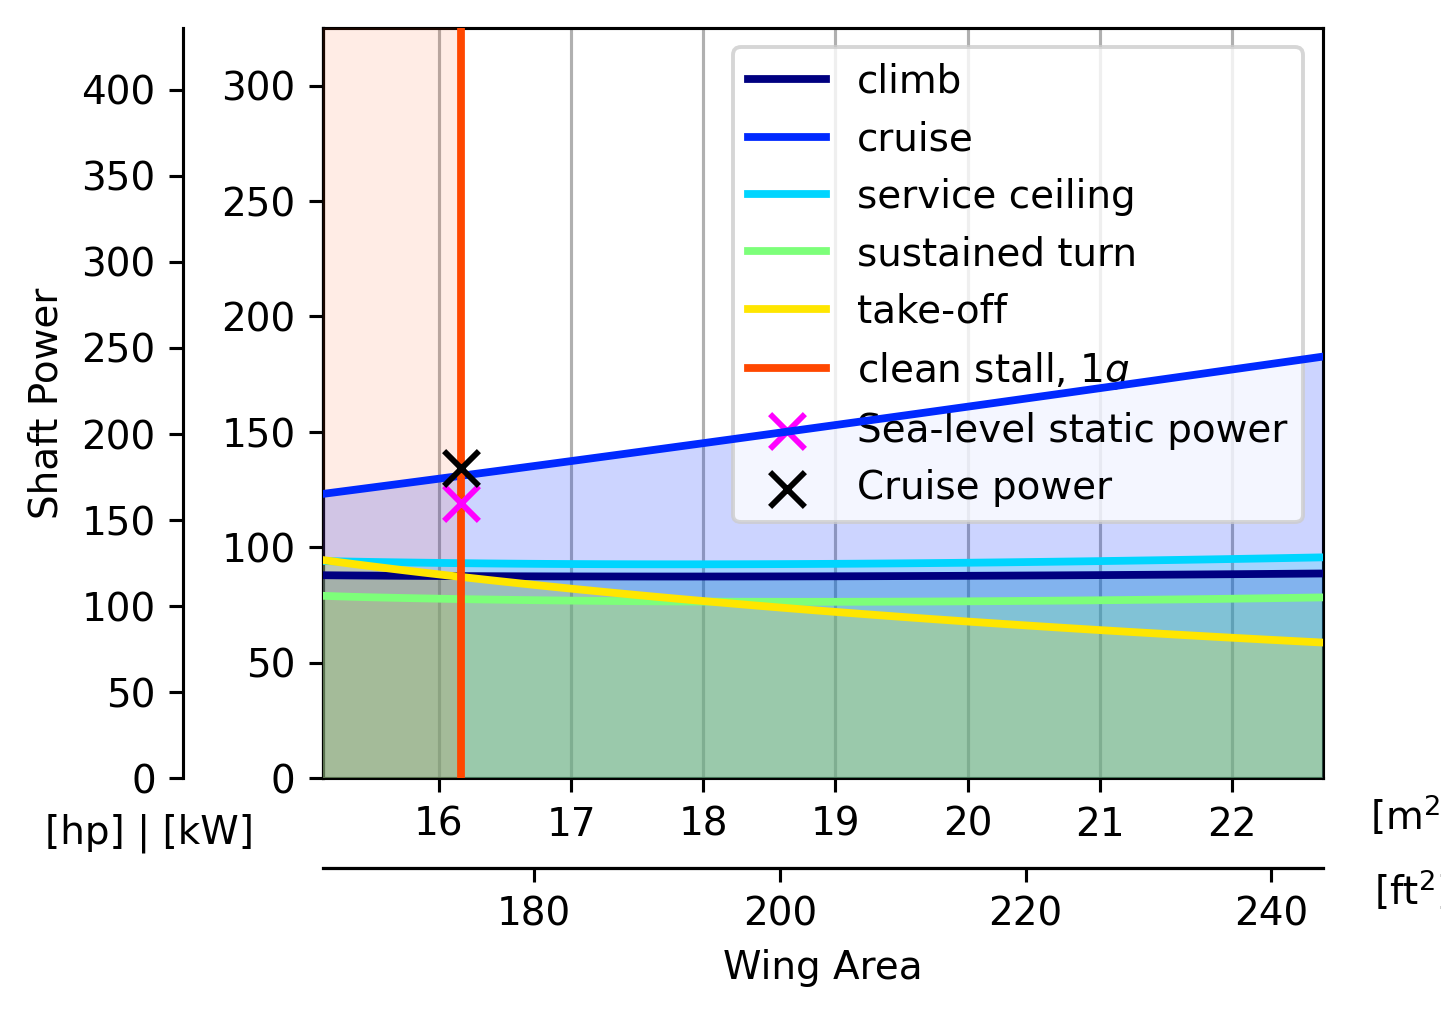

In [12]:
ws_pa = np.linspace(500, 750)        # Step 1
fig, ax = concept.plot_constraints(ws_pa)  # Step 2

common = {"fc": "white", "clip_on": False, "zorder": 100}
ax.scatter(16.17, uc.hp_W(160), marker="x", ec="magenta", s=80, label="Sea-level static power", **common)
ax.scatter(16.17, uc.hp_W(180), marker="x", ec="k", s=80, label="Cruise power", **common)
ax.legend()
fig.savefig("constraints")

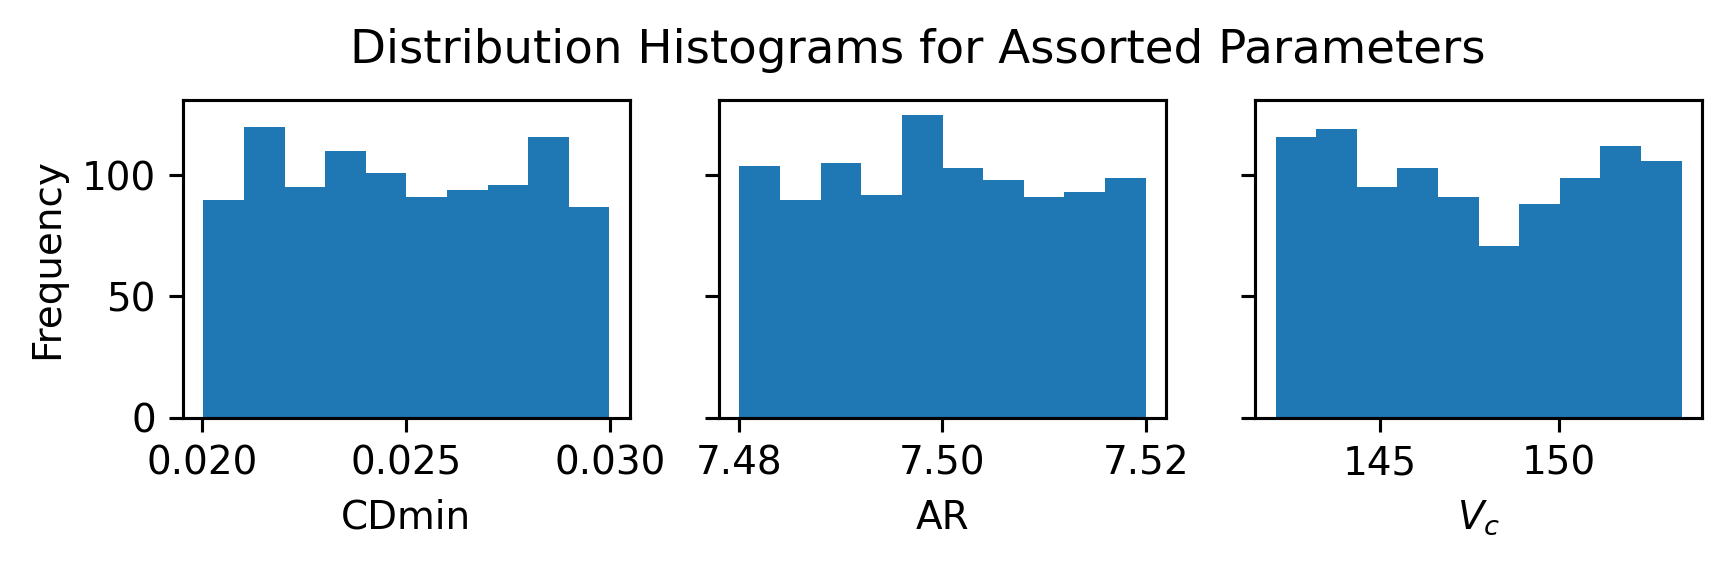

In [19]:
num = 1000

CDmin_mc = np.random.uniform(0.02, 0.03, num)
AR_mc = np.random.uniform(7.48, 7.52, num)
Vcruise_mc = np.random.uniform(at.Atmosphere().EAS_TAS(125, uc.ft_m(8500)), at.Atmosphere().EAS_TAS(135, uc.ft_m(8500)), num)


fig, axs = plt.subplots(1, 3, dpi=140, figsize=(7, 1.6), sharey=True)
fig.suptitle("Distribution Histograms for Assorted Parameters")
fig.subplots_adjust(top=0.82)
axs[0].set_ylabel("Frequency")

inputvars = {"CDmin": CDmin_mc, "AR": AR_mc, "$V_c$": Vcruise_mc}
for i, (label, data) in enumerate(inputvars.items()):
    axs[i].hist(data)
    axs[i].set_xlabel(label)

plt.show()

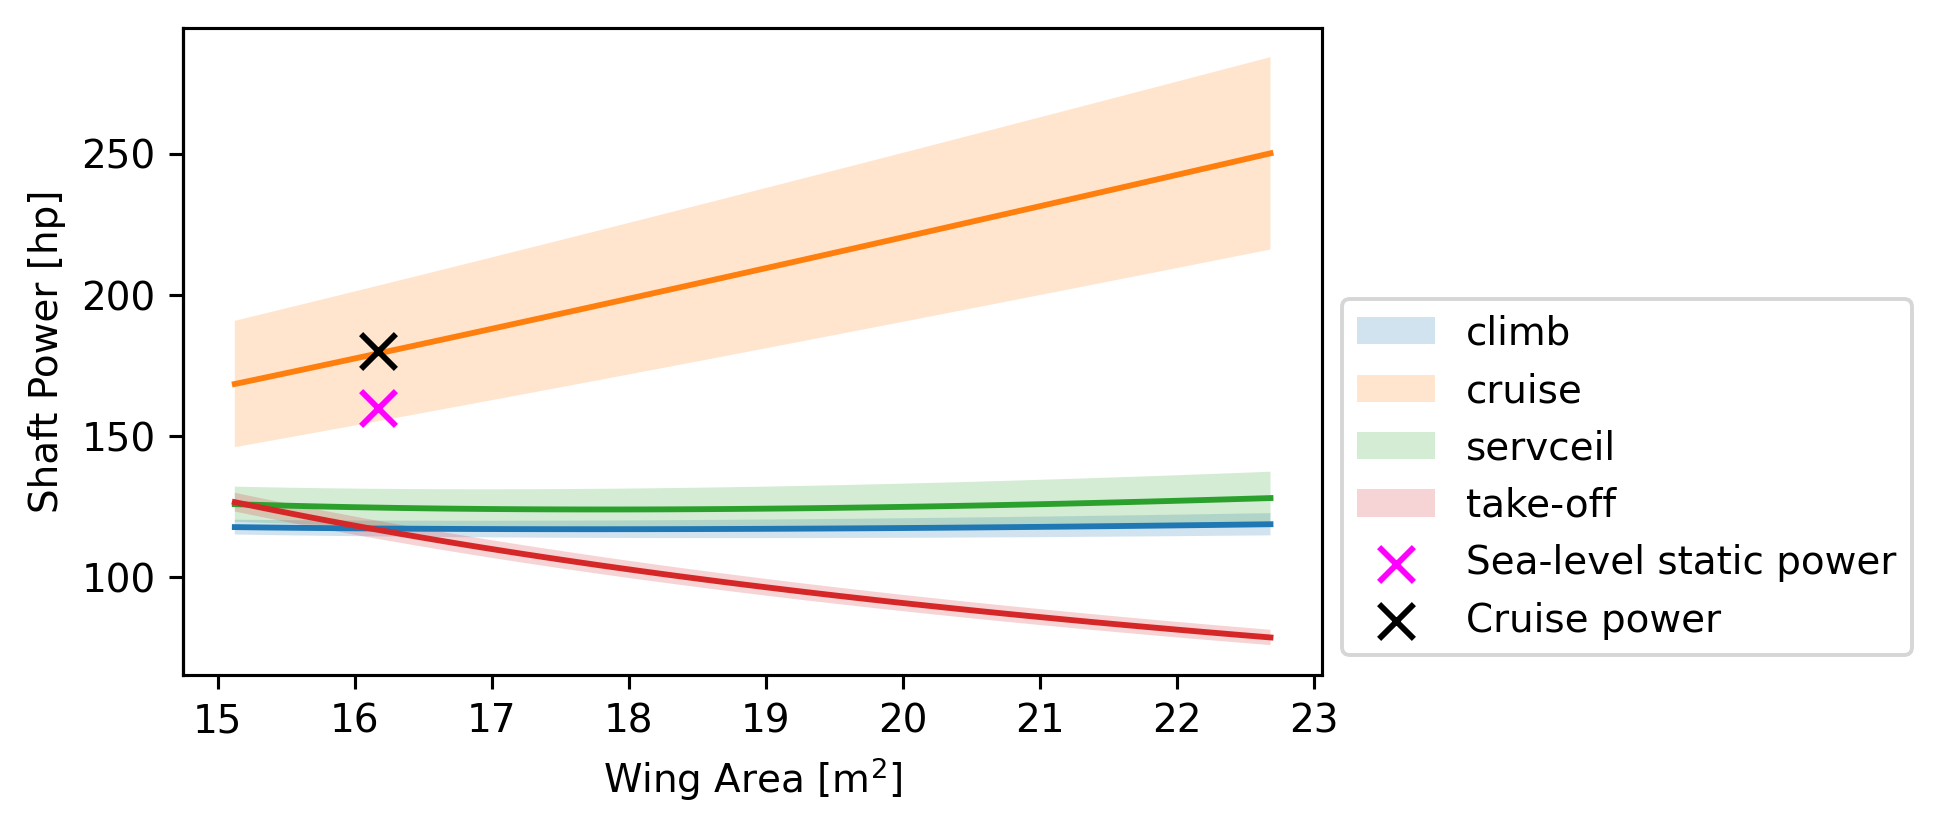

In [22]:
constraintfunctions = {
    "climb": lambda ac_obj: ac_obj.constrain_climb,
    "cruise": lambda ac_obj: ac_obj.constrain_cruise,
    "servceil": lambda ac_obj: ac_obj.constrain_servceil,
    "take-off": lambda ac_obj: ac_obj.constrain_takeoff,
    # "turn": lambda ac_obj: ac_obj.constrain_turn  # <-- Commented to remove that pesky turn constraint!
}

Preqs = {
    name: np.zeros((*ws_pa.shape, num))        # store a key/value pair
    for (name, _) in constraintfunctions.items()  # ... for each key in this other dictionary
}

# Run ndraws number of simulations
for i in range(num):
    
    # Use more dictionary comprehension to create new concept design dictionaries.
    # Using:
    #     new_dict = {**defaults_dict, "key2update": shiny_new_value, ...}
    #
    mc_designbrief = {**designbrief, "cruisespeed_ktas": Vcruise_mc[i]}
    mc_designdef = {**designdefinition, "aspectratio": AR_mc[i]}
    mc_designperformance = {**designperformance, "CDmin": CDmin_mc[i]}
    
    # Slightly different approach for modifying the atmosphere
    mc_designatm = at.Atmosphere()
    
    # Create our Monte Carlo concept for the i'th time
    mc_concept = ca.AircraftConcept(
        brief=mc_designbrief,
        design=mc_designdef,
        performance=mc_designperformance,
        atmosphere=mc_designatm,
        propulsion="Piston"
    )
    
    # For each constraint, compute P/W and then Power
    for label, func in constraintfunctions.items():
        _, mc_pw = func(ac_obj=mc_concept)(ws_pa)
        mc_p = mc_pw * mc_concept.design.weight_n
        
        # Store the computed power in our variable for capturing outputs.
        # e.g.
        #    Preqs["cruise"][:, 62] = mc_p 
        #
        # ... is storing the power computed for each wing loading (dimension 0 --> [:,   ])
        # and we are currently on the 63rd computation            (dimension 1 --> [ , 62])
        Preqs[label][:, i] = mc_p

fig, ax = plt.subplots(dpi=140, figsize=(5.25, 3))

xdata = concept.design.weight_n / ws_pa  # get x-axis

# For each constraint in our output dictionary
for label, _ in Preqs.items():
    
    # Compute the mean and standard deviation
    mu = np.nanmean(Preqs[label], axis=-1)  # axis=-1, average result of the ndraws at each ws_pa
    sig = np.nanstd(Preqs[label], axis=-1, ddof=1)  # ddof=1, sample-corrected standard deviation
    
    # Plot a solid line for the mean, and a shaded region for the +/- 1 standard deviation
    l2d, = ax.plot(xdata, mu)
    ax.fill_between(xdata, mu+sig, mu-sig, label=label, alpha=0.2, fc=l2d.get_color())

# Turn the y-axis ticks displaying units of [W] invisible, and replace with units of [hp]
ax.set_yticks([])
secax_y = ax.secondary_yaxis("left", functions=(uc.W_hp, uc.hp_W))
secax_y.set_ylabel("Shaft Power [hp]")

# Other things to make the plot pretty
ax.set_xlabel("Wing Area [m$^2$]")
ax.scatter(16.17, uc.hp_W(160), marker="x", ec="magenta", s=80, label="Sea-level static power", **common)
ax.scatter(16.17, uc.hp_W(180), marker="x", ec="k", s=80, label="Cruise power", **common)
ax.legend(loc="lower left", bbox_to_anchor=(1, 0));



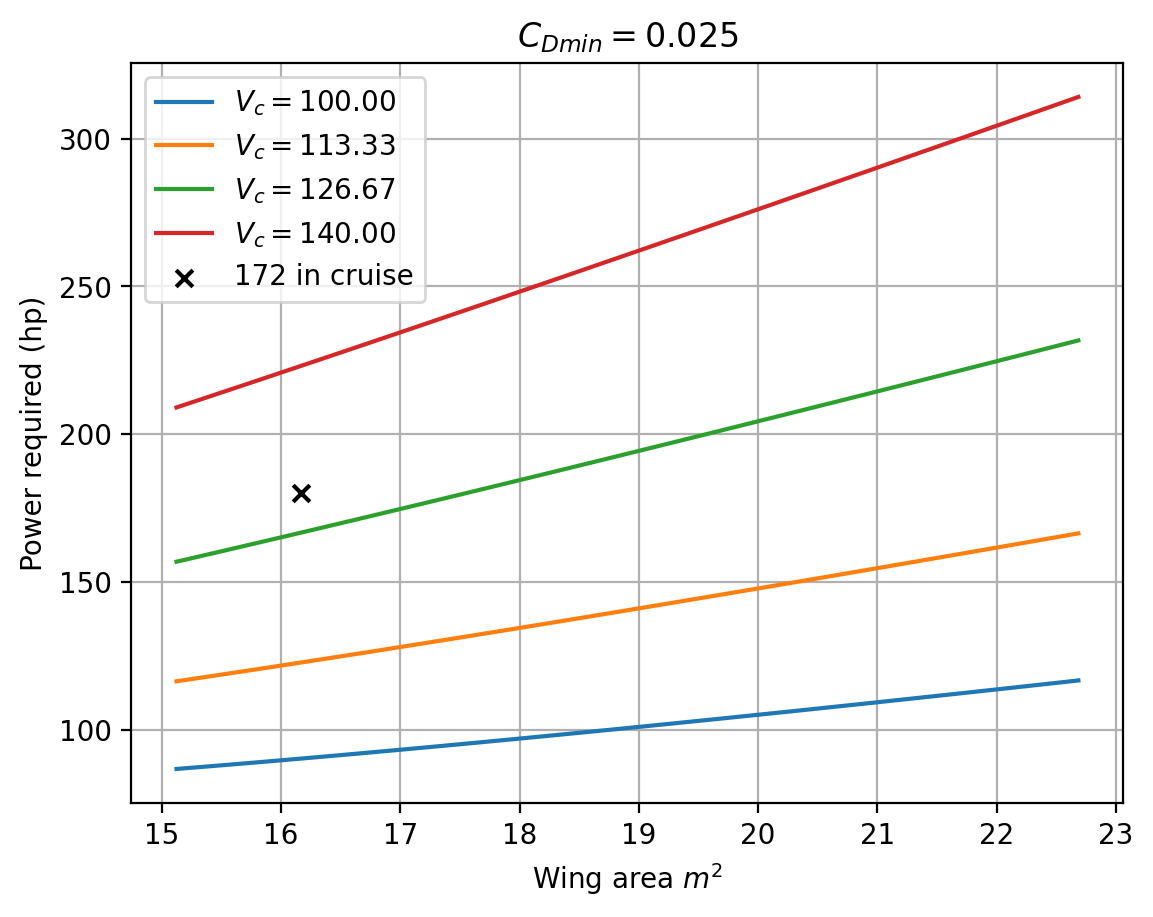

In [122]:
speeds = np.linspace(at.Atmosphere().EAS_TAS(100, uc.ft_m(8500)), at.Atmosphere().EAS_TAS(140, uc.ft_m(8500)), 4)

for speed in speeds:
    sa_designbrief = {**designbrief, "cruisespeed_ktas": speed}
    sa_designdef = {**designdefinition}
    sa_designperformance = {**designperformance, "CDmin": 0.025}
    
    sa_conc = sa_concept = ca.AircraftConcept(
        brief=sa_designbrief,
        design=sa_designdef,
        performance=sa_designperformance,
        atmosphere=at.Atmosphere(),
        propulsion="Piston"
    )
    
    a, wn = sa_conc.constrain_cruise(ws_pa)
    hp = uc.W_hp(wn * L)
    plt.plot(L/ws_pa, hp, label = f"$V_c = {at.Atmosphere().TAS_EAS(speed, uc.ft_m(8500)):.2f}$")
    
plt.scatter(16.17, 180, label = "172 in cruise", marker="x", ec="k")
plt.ylabel("Power required (hp)")
plt.xlabel(r"Wing area $m^2$")
plt.legend()
plt.grid()
plt.title(r"$C_{Dmin} = 0.025$")
plt.savefig("cruise_sensitivity_025")

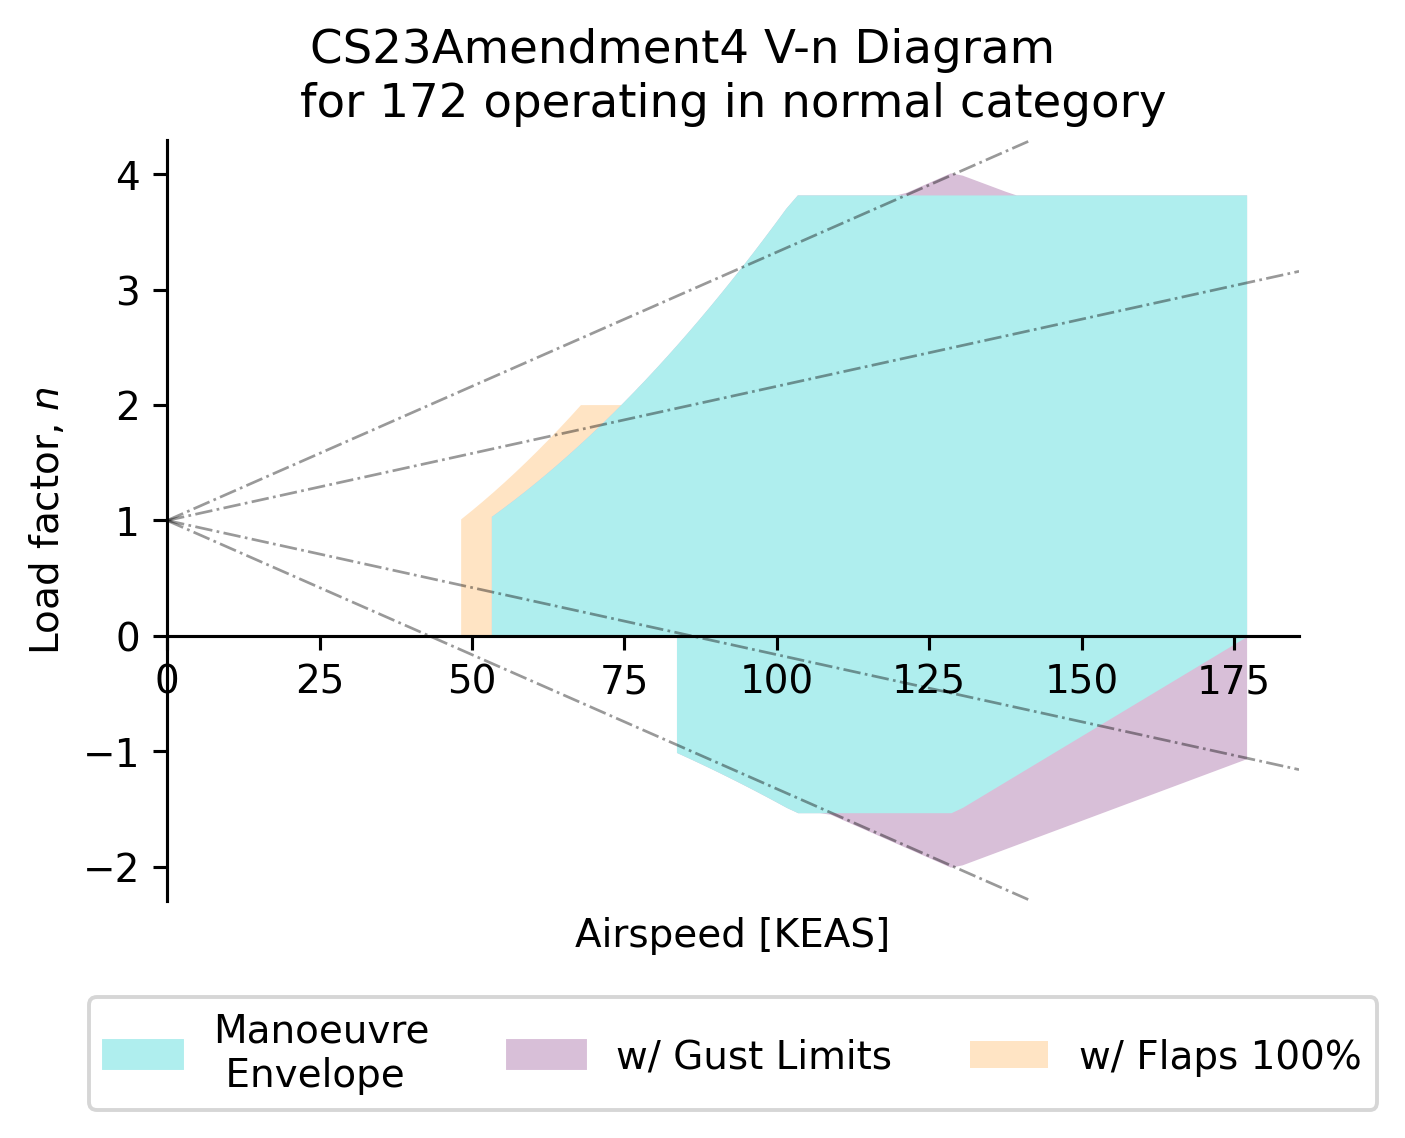

In [7]:
cs23eval = aw.CS23Amendment4(concept, "normal")
fig, ax = cs23eval.plot_Vn()
ax.set_title("for 172 operating in normal category")
fig.savefig("V-n.png")

In [8]:
deck = concept.propulsion
deck.shaftpower(0, uc.ft_m(8500))

0.7440759305782895

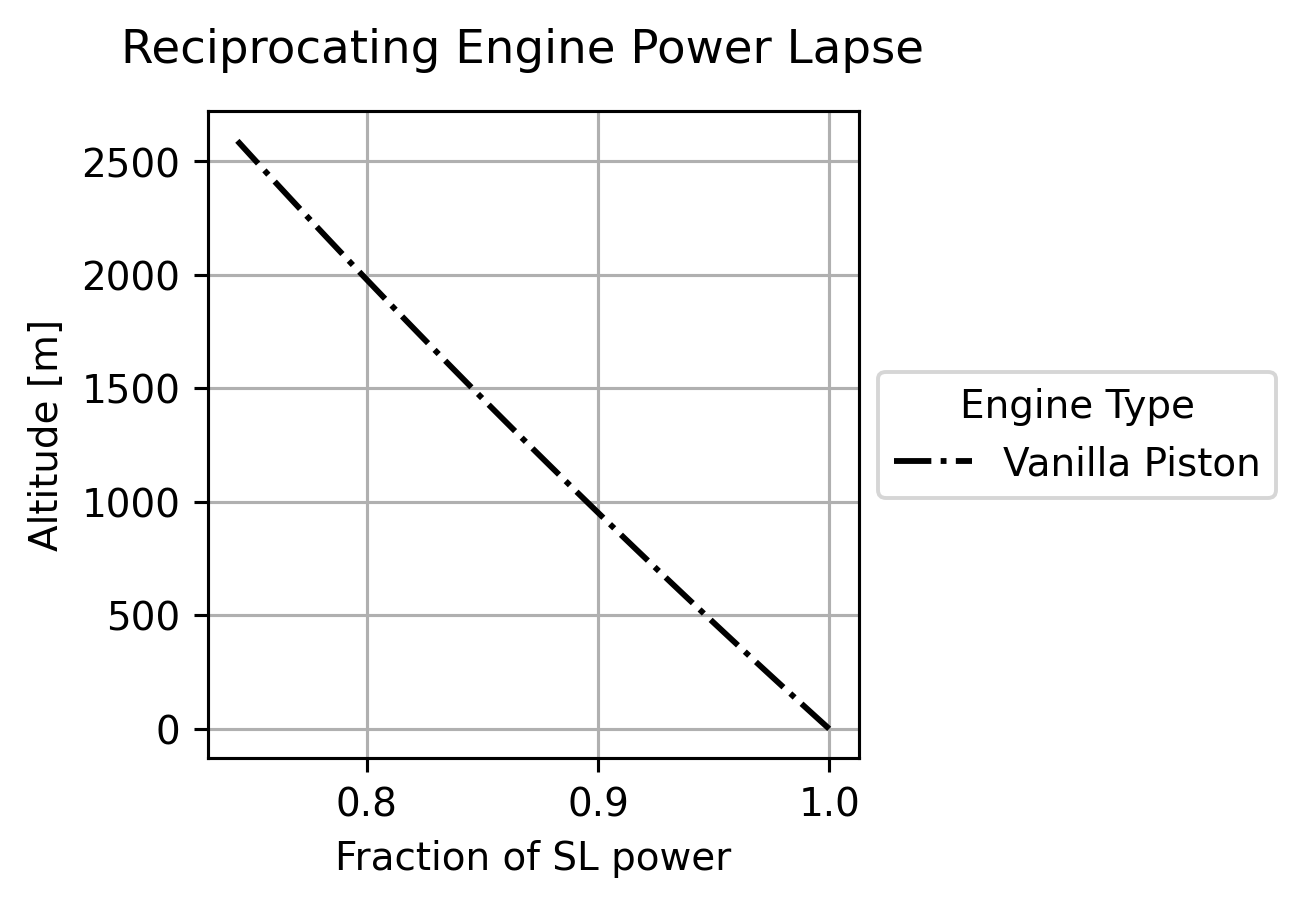

In [9]:
altitudes = np.linspace(0, uc.ft_m(8500))

fig, ax = plt.subplots(dpi=140, figsize=(3, 3))

powerkwargs = {"mach": None, "altitude_m":altitudes}
ax.plot(Piston.shaftpower(**powerkwargs), altitudes, label="Vanilla Piston", c="k", ls="-.")

fig.suptitle("Reciprocating Engine Power Lapse")
ax.set_xlabel("Fraction of SL power")
ax.set_ylabel("Altitude [m]")
ax.legend(title="Engine Type", bbox_to_anchor=(1, 0.5), loc="center left")
ax.grid()

plt.show()

In [10]:
AR

7.482993197278911

In [119]:
L

11342.962247952706